This notebook reads in a selected region of ALL SLCs, creates skip1 interferograms with them, and outputs the igram as an ISCE-readable file for using with SNAPHU. 


This notebook: <br>
(loops over all SLCs and does the following each time)
1. Reads in small window (defined in 'extract_ONE_igram...ipynb') of two SLCs 
2. Filters and creates skip1 interferogram with them
3. Saves the full res igram as a temporary ISCE-readable file. (next time it will overwrite the igram file)
4. Unwraps it with SNAPHU, saves the unwrapped version. 

This notebook was copied from 'extract_ALL_sequential_igrams_and_unwrap.ipynb' and edited on 3-28-23.

***

Import the things we need.

In [1]:
import os,sys
import glob
import pandas as pd
import math
from osgeo import gdal
import numpy as np
from array import array
from scipy  import signal
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter
import isce
import isceobj
from contrib.Snaphu.Snaphu import Snaphu
import shutil
from imageMath import IML
# %matplotlib  widget

Using default ISCE Path: /home/rlohman/Software/isce-2.2.0/isce


Set the working directory and define dimensions of the SLC files we'll be loading in

In [5]:
workdir = '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/'
temp_outputdir = str(workdir+'cropped_northern_shore_LS_for_unwrapping/')
outputdir = str(temp_outputdir+'filt_unwrapped/')

# size of full res SLCs
dxIN=18000
dyIN=3600

If filtering first, use this window for filtering 

In [3]:
alooks=4
rlooks=20

Load in the dates of the SLCs for loading them.

In [4]:
# load in dates
dates = [os.path.basename(x) for x in glob.glob(workdir+"SLC_vv/2*")]
dates = sorted(dates)
nd = len(dates)
print(dates)

['20170510', '20170522', '20170603', '20170615', '20170627', '20170709', '20170721', '20170802', '20170814', '20170826', '20170907', '20170919', '20171013', '20171025', '20171106', '20171118', '20171130', '20171212', '20171224', '20180105', '20180117', '20180129', '20180210', '20180222', '20180306', '20180318', '20180330', '20180411', '20180423', '20180505', '20180517', '20180529', '20180610', '20180622', '20180704', '20180716', '20180728', '20180809', '20180821', '20180902', '20180914', '20180926', '20181008', '20181020', '20181101', '20181113', '20181125', '20181207', '20181219', '20181231', '20190112', '20190124', '20190205', '20190217', '20190301', '20190313', '20190325', '20190406', '20190430', '20190512', '20190524', '20190605', '20190617', '20190629', '20190711', '20190723', '20190804', '20190816', '20190822', '20190828', '20190903', '20190909', '20190915', '20190921', '20190927', '20191003', '20191009', '20191015', '20191021', '20191027', '20191102', '20191108', '20191114', '20

Read in 2 SLCs for full res unwrapping with SNAPHU.

In [6]:
# bounding box
x1 = 17000; x2 = 14000
y1 = 1750;  y2 = 1000
# output file size
dxOUT = int(np.abs(x1-x2))
dyOUT = int(np.abs(y1-y2))
print('range: '+str(dxOUT))
print('azimuth: '+str(dyOUT))
print('total number of pixels: '+str(dxOUT*dyOUT))
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')

# loop through the dates 
for i in range(nd-2): # range(nd-2) if doing all of them at once
    # define the 2 dates. 
    date1=dates[i]
    date2=dates[i+2] # SKIP1
    # Read in 2 full SLCs to make interferogram 
    ds = gdal.Open(workdir+"/SLC_vv/"+date1+"/"+date1+".slc.full", gdal.GA_ReadOnly)
    slc1 = ds.GetRasterBand(1).ReadAsArray(x2,y2,dxOUT,dyOUT)
    #print('SLC 1 subsect loaded.')
    ds = gdal.Open(workdir+"/SLC_vv/"+date2+"/"+date2+".slc.full", gdal.GA_ReadOnly)
    slc2 = ds.GetRasterBand(1).ReadAsArray(x2,y2,dxOUT,dyOUT)
    #print('SLC 2 subsect loaded.')
    intTemp = (slc1*np.conj(slc2)) # NOT ANGLE

    # This filtering is optional 
    s1=slc1*np.conj(slc1)
    s2=slc2*np.conj(slc2)
    a1r=gaussian_filter(np.real(s1), sigma=[alooks/4,rlooks/4])
    a1i=gaussian_filter(np.imag(s1), sigma=[alooks/4,rlooks/4])
    a2r=gaussian_filter(np.real(s2), sigma=[alooks/4,rlooks/4])
    a2i=gaussian_filter(np.imag(s2), sigma=[alooks/4,rlooks/4])
    a1 = a1r+1j*a1i
    a2 = a2r+1j*a2i
    filtimager=gaussian_filter(np.real(intTemp), sigma=[alooks/4,rlooks/4])
    filtimagei=gaussian_filter(np.imag(intTemp), sigma=[alooks/4,rlooks/4])
    intTemp = filtimager+1j*filtimagei
    #scaler    = np.sqrt(a1*a2)
    #intTemp = intTemp/scaler
    
    # save the file 
    igramFile = 'filtigramTemp1.r4'
    colds = driver.Create(temp_outputdir+igramFile,dxOUT,dyOUT,1,gdal.GDT_Float32)
    colds.GetRasterBand(1).WriteArray(np.angle(intTemp))
    colds=None
    
    # output a string SNAPHU output (unwrapped) file to be named. 
    outfile = outputdir+date1+'_'+date2+'_filt.unw'
    #print(outfile)
    inputFilename = temp_outputdir+igramFile
    # try using SNAPHU in the loop
    #! start_isce
    #! python /data/ocp4/LagunaSalada/testSnaphu.py '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/igramTemp.r4' outfile
    #inputFilename = sys.argv[1]
    #outputFilename = sys.argv[2]
    snaphu = Snaphu()
    snaphu.setInput(inputFilename)
    snaphu.setOutput(outfile)
    snaphu.setWidth(3000) # this was 4800 for Rowena's test 
    snaphu.setCostMode('DEFO') # try SMOOTH, was DEFO to start
    snaphu.setEarthRadius(6356236.24233467)
    snaphu.setWavelength(0.0562356424)
    snaphu.setAltitude(788151.7928135)
    snaphu.setCorFileFormat('FLOAT_DATA')
    snaphu.setIntFileFormat('FLOAT_DATA')
    snaphu.setUnwFileFormat('FLOAT_DATA')

    print("Preparing")
    snaphu.prepare()
    snaphu.unwrap()

    copyThisFile = temp_outputdir+'igramTemp.r4.xml'
    putItHere = outputdir+date1+'_'+date2+'_filt.unw.xml'
    # copy the file
    shutil.copy(copyThisFile,putItHere)

    # can comment out everything beyond this
    # don't need .vrt or .xml.xml files so this part isn't necessary 

    #infile = outputdir+date1+'_'+date2+'_filt_unwr.int'
    # img, dataname, metaName = IML.loadImage(inps.infile) # original line
    #img, dataname, metaName = IML.loadImage(infile)
    # #img.filename = fname # original line of code 
    #img.filename = putItHere
    #img.setAccessMode('READ')
    #img.renderHdr()
    # for some reason this makes an extra .xml.xml and .xml.vrt files that are unecessary, remove them 
    #os.remove(putItHere+'.xml')
    #os.remove(putItHere+'.vrt')

# call this from command line with this:
# python testSnaphu.py infile outfile

range: 3000
azimuth: 750
total number of pixels: 2250000
Preparing

snaphu v1.4.2
Reading wrapped phase from file /data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/filtigramTemp1.r4
No weight file specified.  Assuming uniform weights
No correlation file specified.  Assuming correlation = 0.01
Calculating deformation-mode cost parameters
Initializing flows with MST algorithm
Running nonlinear network flow optimizer
Maximum flow on network: 1
Flow increment: 1  (Total improvements: 0)
Growing connected component mask
Writing connected components to file /data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/filt_unwrapped/20170510_20170603_filt.unw.conncomp
Maximum flow on network: 1
Total solution cost: 262909
Integrating phase
Writing output to file /data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/filt_unwrapped/20170510_20170603_filt.unw


can look in documentation in IML packagePathMap
set width, some generic header? 

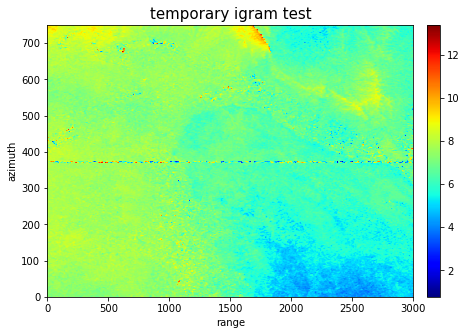

In [9]:
# test the one output I just did with fixImageXml code 

# load in unwrapped file and plot it to be sure SNAPHU worked. 
#f1 = gdal.Open((outputdir+'20191021_20191027_unwr.r4'), gdal.GA_ReadOnly)
file = '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/filt_unwrapped/20170510_20170603_filt.unw'
f1 = gdal.Open((file), gdal.GA_ReadOnly)
unwr_igram = f1.ReadAsArray()
f1 = None

# now plot it
fig = plt.figure(figsize=(8,5))
ax = plt.axes()
im = plt.pcolor(np.flipud(np.fliplr(unwr_igram)))
plt.colorbar(orientation='vertical',pad=0.03)
plt.set_cmap('jet')
ax.ylabel_style = {'size': 15, 'color': 'black'}
ax.xlabel_style = {'size': 15, 'color': 'black'}
plt.title('temporary igram test',fontsize=15)
plt.xlabel('range'); plt.ylabel('azimuth')
plt.show()